# Kish Basin Statistics

In [1]:
import os

import cartopy.crs as ccrs
import contextily as cx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from src import functions as fns

In [2]:
# data directory
DATA_DIR = os.path.join("data", "kish-basin")

CRS = 23029

# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Read data layers

In [3]:
ds, extent = fns.read_dat_file(DATA_DIR, CRS)

In [4]:
ds

<xarray.Dataset>
Dimensions:      (halite: 4, y: 237, x: 218)
Coordinates:
  * y            (y) float64 5.936e+06 5.936e+06 ... 5.889e+06 5.889e+06
  * x            (x) float64 6.966e+05 6.968e+05 6.97e+05 ... 7.398e+05 7.4e+05
    spatial_ref  int64 0
  * halite       (halite) <U8 'Fylde' 'Mythop' 'Preesall' 'Rossall'
Data variables:
    BaseDepth    (halite, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    Thickness    (halite, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    TopDepth     (halite, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    TopTWT       (halite, y, x) float64 nan nan nan nan nan ... nan nan nan nan

In [5]:
ds.rio.crs

CRS.from_epsg(23029)

In [6]:
ds.rio.resolution()

(200.0, -200.0)

In [7]:
ds.rio.bounds()

(696500.0, 5889100.0, 740100.0, 5936500.0)

In [8]:
def plot_facet_maps(dat_xr, dat_extent, dat_crs):
    """
    Helper function to plot facet maps of the halite layers

    Parameters
    ----------
    dat_xr : Xarray dataset of the halite data
    dat_extent : extent of the data
    dat_crs : EPSG CRS
    """

    xmin_, ymin_, xmax_, ymax_ = dat_extent.total_bounds

    for v in dat_xr.data_vars:
        f = dat_xr[v].plot.contourf(
            col="halite",
            robust=True,
            levels=15,
            cmap="jet",
            col_wrap=2,
            subplot_kws={"projection": ccrs.epsg(dat_crs)},
            xlim=(xmin_, xmax_),
            ylim=(ymin_, ymax_),
        )
        # add a basemap
        basemap = cx.providers.CartoDB.PositronNoLabels
        for n, axis in enumerate(f.axs.flat):
            cx.add_basemap(
                axis, crs=dat_crs, source=basemap, attribution=False
            )
            # add attribution for basemap tiles
            if n == 2:
                axis.text(
                    xmin_, ymin_ - 2500, basemap["attribution"], fontsize=8
                )
        f.set_titles("{value}", weight="semibold")
        plt.show()

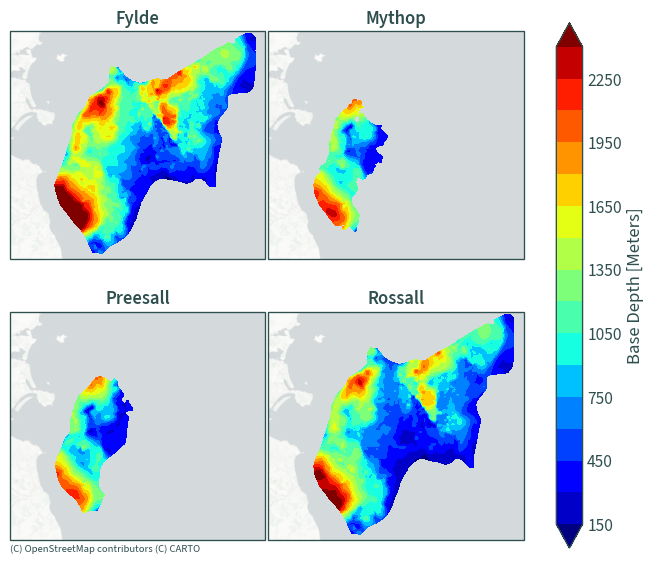

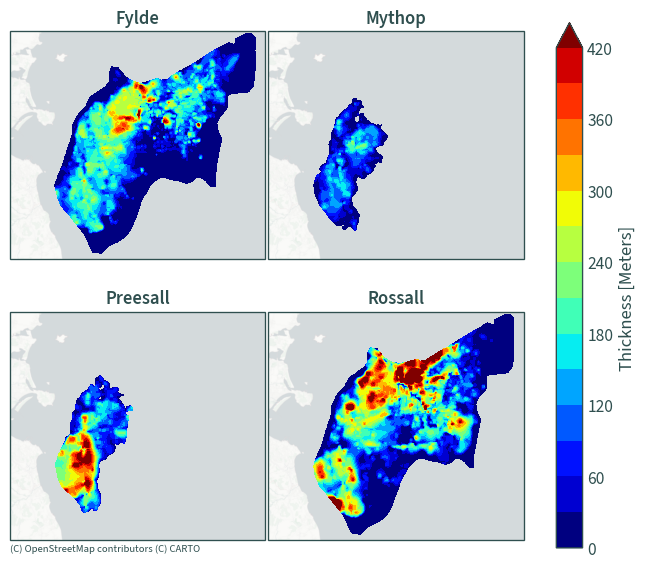

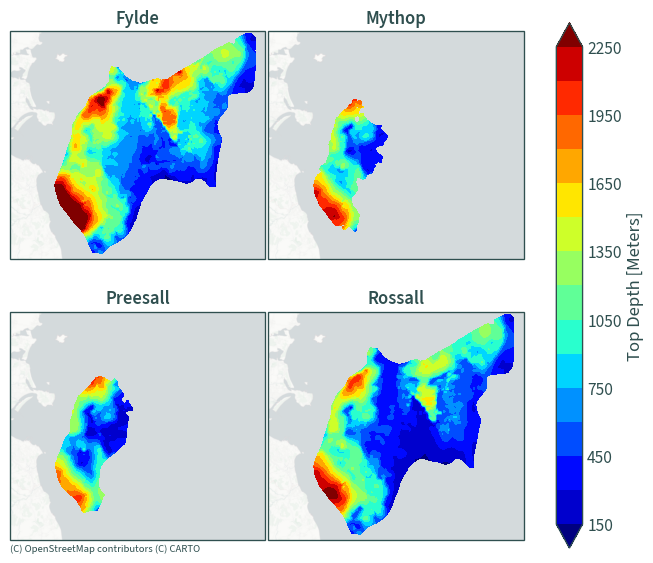

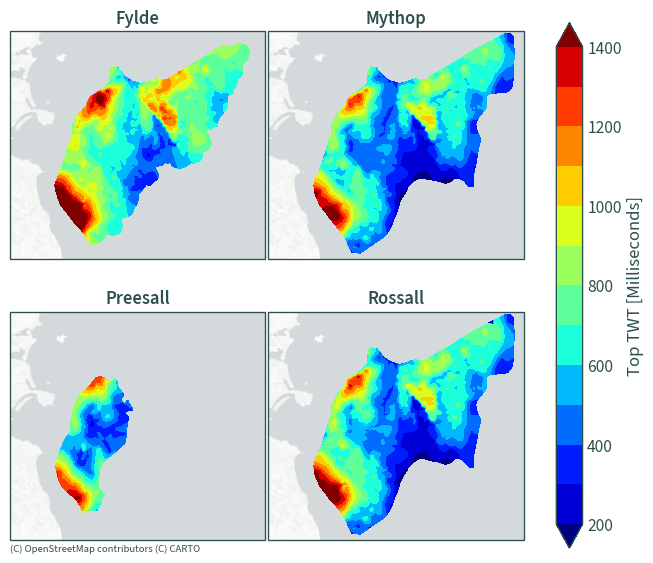

In [9]:
plot_facet_maps(ds, extent, CRS)

## Stats

In [48]:
def make_stats_plots(dat_xr):
    """
    Statistical plots for the halite Xarray dataset

    Parameters
    ----------
    dat_xr : Xarray dataset of the halite data

    Returns
    -------
    - The dataset converted into a dataframe
    """

    # convert to dataframe
    dat_df = dat_xr.to_dataframe()[list(dat_xr.data_vars)]

    # pairwise comparison of variables
    sns.pairplot(
        dat_df.reset_index(), palette="flare", hue="halite",
        plot_kws={"alpha": .5}, vars=["Thickness", "TopDepth", "BaseDepth"]
    )
    plt.show()

    # histograms
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(
        dat_df.reset_index(), x="Thickness", hue="halite", ax=axes[0],
        palette="rocket_r", multiple="fill", bins=100, legend=False
    )
    sns.histplot(
        dat_df.reset_index(), x="TopDepth", hue="halite", ax=axes[1],
        palette="rocket_r", multiple="fill", bins=100
    )
    plt.tight_layout()
    plt.show()

    # box plots
    fig, axes = plt.subplots(1, 3, figsize=(8, 4.5))
    sns.boxplot(
        dat_df.reset_index(), y="Thickness", hue="halite", palette="flare",
        ax=axes[0]
    )
    sns.boxplot(
        dat_df.reset_index(), y="TopDepth", hue="halite", palette="flare",
        ax=axes[1], legend=False
    )
    sns.boxplot(
        dat_df.reset_index(), y="BaseDepth", hue="halite", palette="flare",
        ax=axes[2], legend=False
    )
    plt.tight_layout()
    plt.show()

    return dat_df

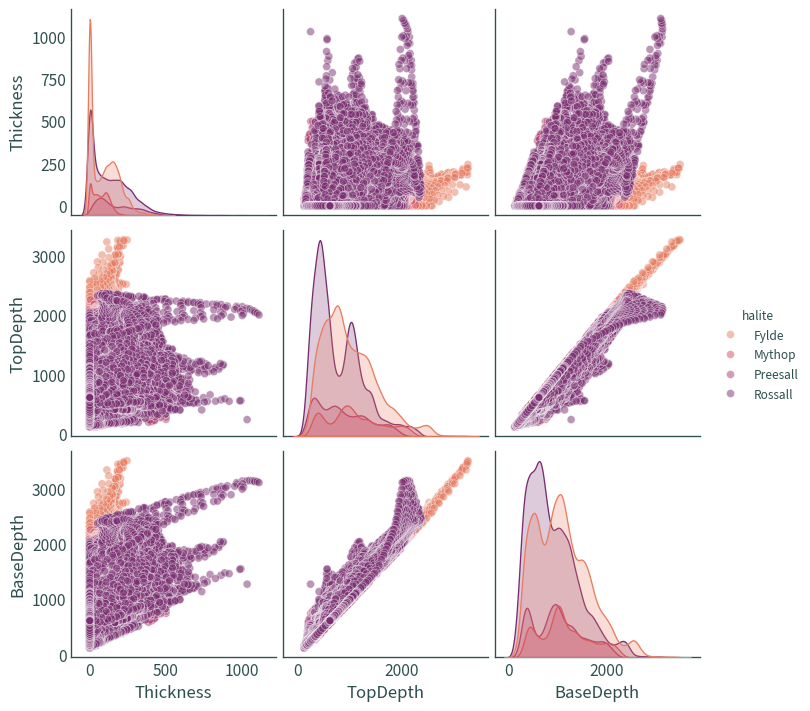

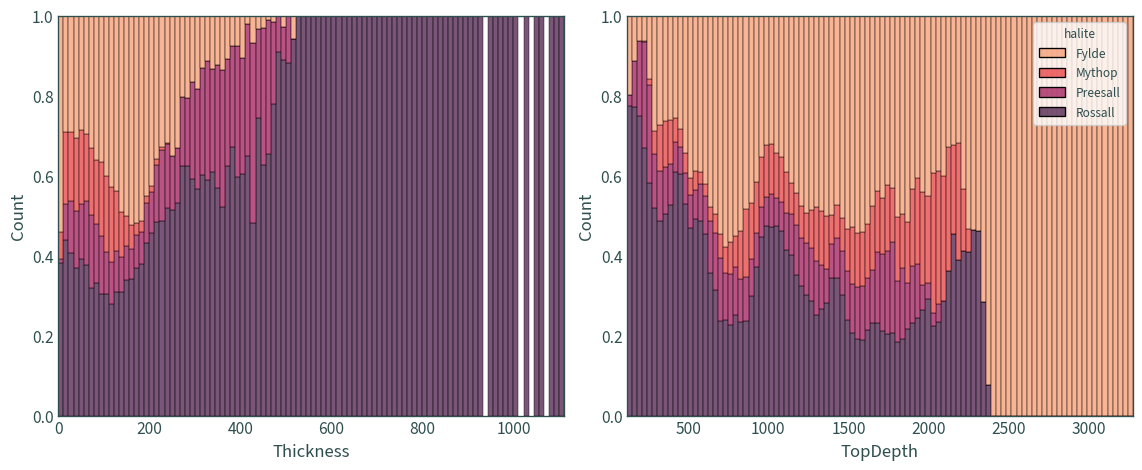

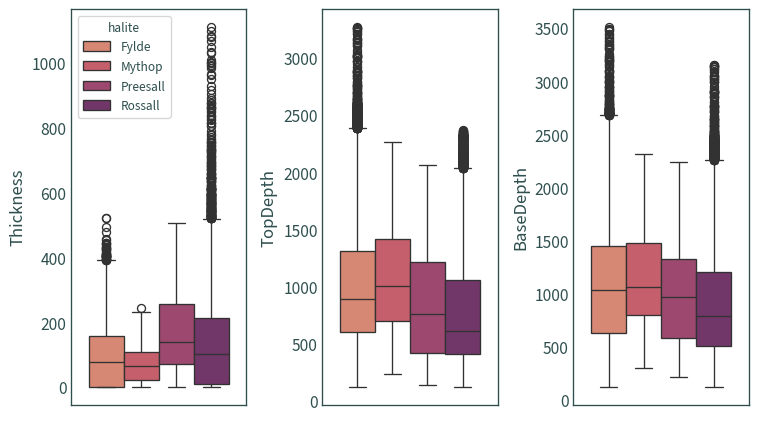

In [49]:
df = make_stats_plots(ds)

In [12]:
df.describe()

,BaseDepth,Thickness,TopDepth,TopTWT
count,63868.000000,63456.000000,63868.000000,80386.000000
mean,1011.301702,112.835875,899.392295,653.242487
std,536.478279,113.380006,507.401263,259.464713
min,120.324500,0.000000,120.324500,136.616000
25%,574.370900,4.344600,476.546675,468.859575
50%,952.930250,90.634850,818.911100,631.917300
75%,1334.956375,178.472675,1207.349725,776.623200
max,3512.489700,1111.067000,3273.030800,1911.048300


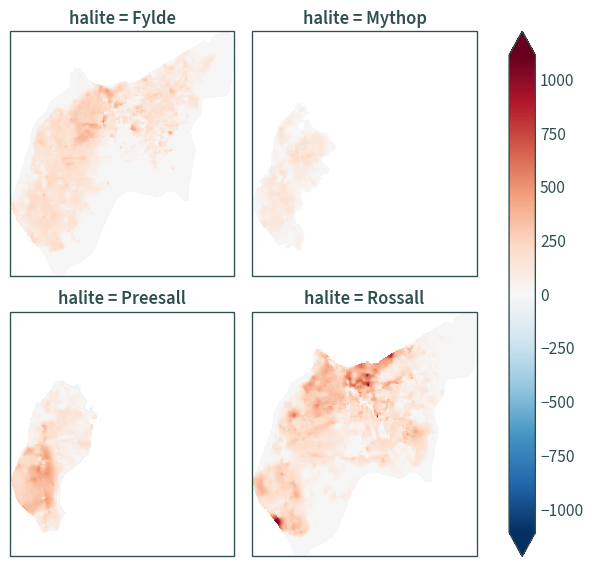

In [13]:
# compare depths
(ds["BaseDepth"] - ds["TopDepth"]).plot(
    col="halite", col_wrap=2, extend="both",
    subplot_kws={"projection": ccrs.epsg(CRS)},
)
plt.show()

In [14]:
min(set((ds["BaseDepth"] - ds["TopDepth"]).values.flatten()))

-53.5

In [15]:
max(set((ds["BaseDepth"] - ds["TopDepth"]).values.flatten()))

1111.0679

## Zones of interest

### With max depth

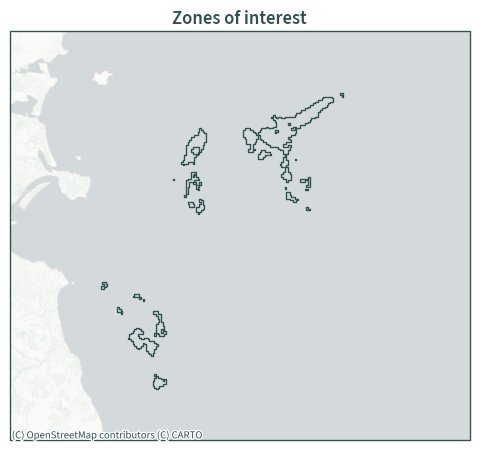

In [16]:
# numbers used in HYSS calculations
# thickness >= 300 m, 1000 m <= depth <= 1500 m, diameter = 85 m
# separation = 330 m
zones_max_depth, zds_max_depth = fns.zones_of_interest(
    ds, extent, CRS,
    {"min_thickness": 300, "min_depth": 1000, "max_depth": 1500}
)

### Without max depth

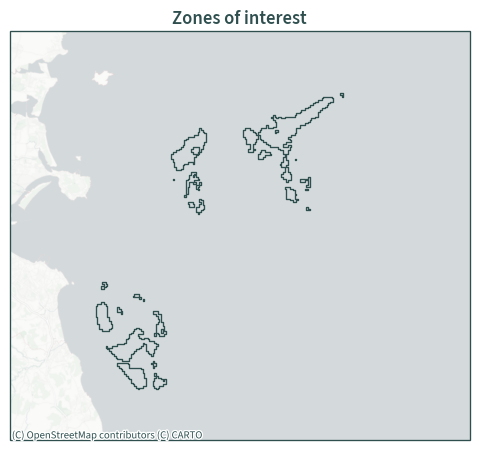

In [17]:
# numbers used in HYSS calculations
# thickness >= 300 m, 1000 m <= depth <= 1500 m, diameter = 85 m
# separation = 330 m
zones_min_depth, zds_min_depth = fns.zones_of_interest(
    ds, extent, CRS, {"min_thickness": 300, "min_depth": 1000}
)

## Zones of interest stats

### With max depth

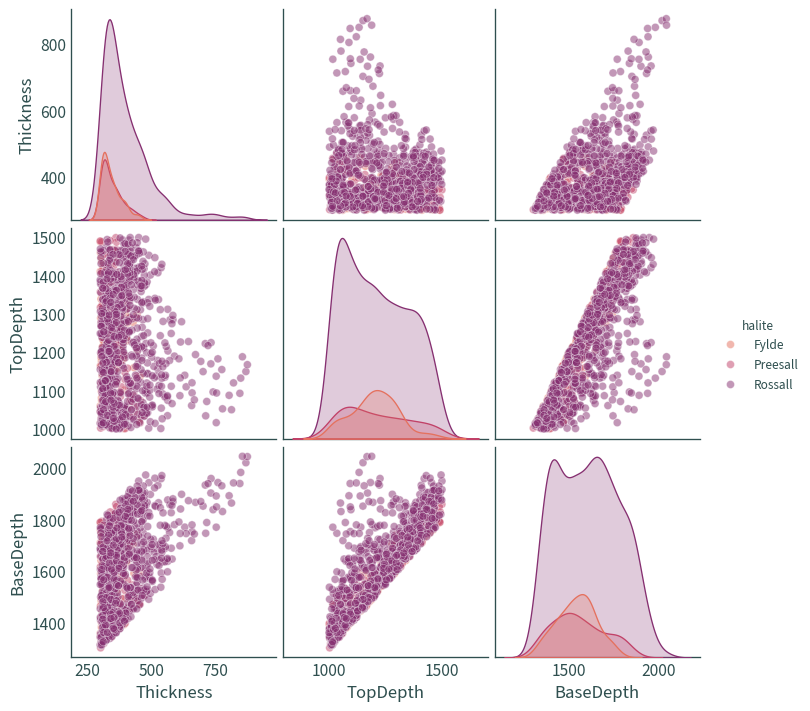

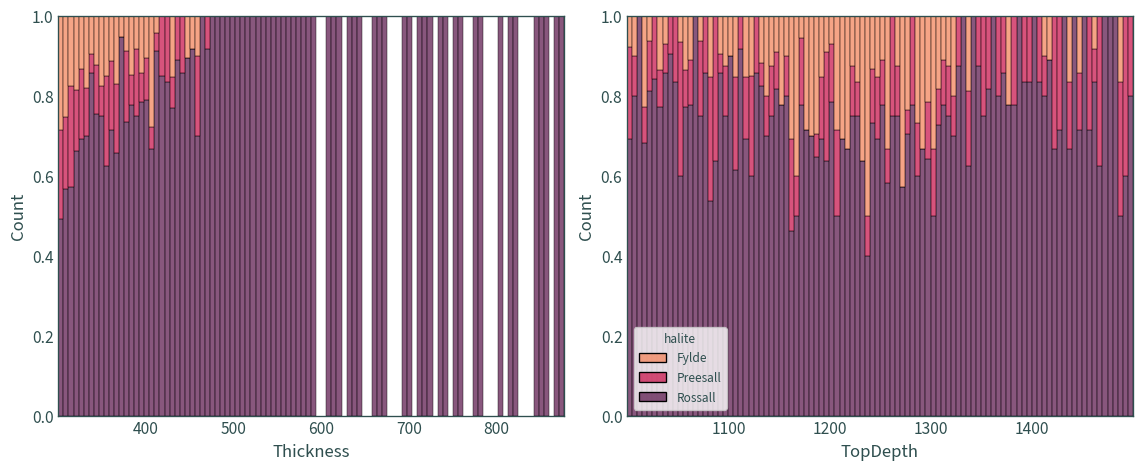

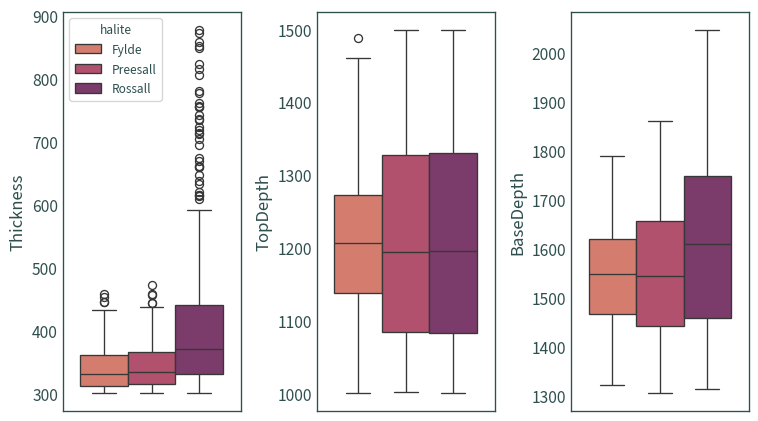

In [50]:
zdf_max_depth = make_stats_plots(zds_max_depth)

In [19]:
zdf_max_depth.describe()

,BaseDepth,Thickness,TopDepth,TopTWT
count,1083.000000,1083.000000,1083.000000,1083.000000
mean,1595.485859,385.637362,1209.848497,805.993834
std,163.222260,90.468818,137.930903,96.597518
min,1304.445200,300.198500,1000.017100,625.339500
25%,1456.160350,324.322150,1089.126400,724.868350
50%,1584.044200,356.411000,1195.798300,795.055300
75%,1718.836300,416.067600,1316.857150,878.153000
max,2045.991200,877.043200,1499.461100,1090.956900


### Without max depth

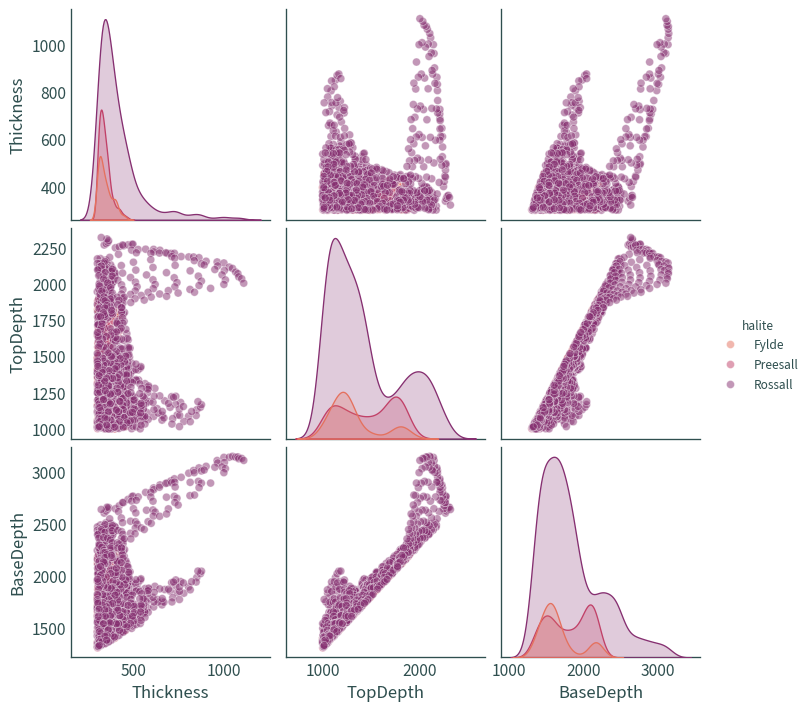

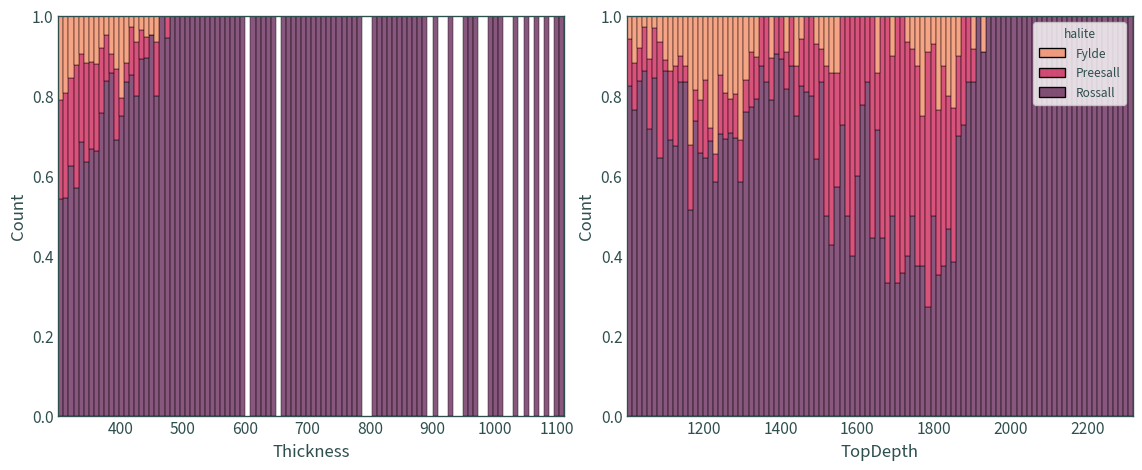

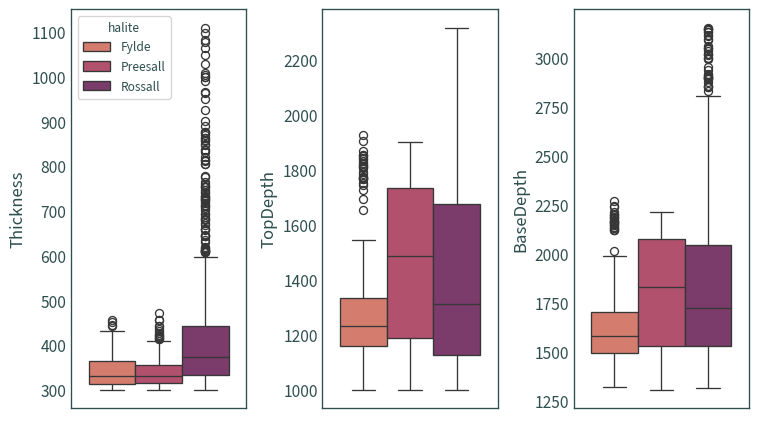

In [51]:
zdf_min_depth = make_stats_plots(zds_min_depth)

In [21]:
zdf_min_depth.describe()

,BaseDepth,Thickness,TopDepth,TopTWT
count,1598.000000,1598.000000,1598.000000,1598.000000
mean,1812.210385,394.529770,1417.680612,943.473772
std,381.714449,117.000475,341.429394,228.823001
min,1304.445200,300.198500,1000.017100,625.339500
25%,1521.580725,325.649500,1138.296675,754.145075
50%,1709.045300,357.555600,1311.182800,874.934200
75%,2043.187050,415.618525,1696.689000,1118.276750
max,3155.030800,1111.067000,2319.127700,1572.047700


## Sensitivity analysis

Sensitivity of maximum halite area (i.e. zones of interest) available for
cavern construction (without constraints) to depth and thickness

In [22]:
def sensitivity(zones_gdf, include_max_depth=True):

    sdf = {}

    # sensitivity to minimum thickness
    thickness_min = [200 + 5 * n for n in range(41)]
    area_max = []

    for t in thickness_min:
        area_max.append(
            fns.zones_of_interest(
                ds, extent, CRS,
                {"min_thickness": t, "min_depth": 1000, "max_depth": 1500},
                display_map=False
            )[0].area[0]
        )

    sdf["min_thickness"] = pd.DataFrame(
        {"max_area": area_max, "min_thickness": thickness_min}
    )

    # percentage change
    sdf["min_thickness"]["diff_area"] = (
        (
            sdf["min_thickness"]["max_area"] - zones_gdf.area[0]
        ) / zones_gdf.area[0] * 100
    )

    # sensitivity to minimum depth
    depth_min = [500 + 12.5 * n for n in range(49)]
    area_max = []

    for t in depth_min:
        area_max.append(
            fns.zones_of_interest(
                ds, extent, CRS,
                {"min_thickness": 300, "min_depth": t, "max_depth": 1500},
                display_map=False
            )[0].area[0]
        )

    sdf["min_depth"] = pd.DataFrame(
        {"max_area": area_max, "min_depth": depth_min}
    )

    # percentage change
    sdf["min_depth"]["diff_area"] = (
        (
            sdf["min_depth"]["max_area"] - zones_gdf.area[0]
        ) / zones_gdf.area[0] * 100
    )

    if include_max_depth:
        # sensitivity to maximum depth
        depth_max = [1400 + 12.5 * n for n in range(57)]
        area_max = []

        for t in depth_max:
            area_max.append(
                fns.zones_of_interest(
                    ds, extent, CRS,
                    {"min_thickness": 300, "min_depth": 1000, "max_depth": t},
                    display_map=False
                )[0].area[0]
            )

        sdf["max_depth"] = pd.DataFrame(
            {"max_area": area_max, "max_depth": depth_max}
        )

        # percentage change
        sdf["max_depth"]["diff_area"] = (
            (
                sdf["max_depth"]["max_area"] - zones_gdf.area[0]
            ) / zones_gdf.area[0] * 100
        )

    return sdf

### With max depth

In [23]:
sdf_max_depth = sensitivity(zones_max_depth)

In [24]:
for key in sdf_max_depth.keys():
    print(key)
    print(sdf_max_depth[key].describe())

min_thickness
           max_area  min_thickness   diff_area
count  4.100000e+01      41.000000   41.000000
mean   5.609073e+07     300.000000   29.599657
std    3.806630e+07      59.895743   87.953554
min    1.312000e+07     200.000000  -69.685767
25%    2.364000e+07     250.000000  -45.378928
50%    4.328000e+07     300.000000    0.000000
75%    8.456000e+07     350.000000   95.378928
max    1.395600e+08     400.000000  222.458410
min_depth
           max_area    min_depth   diff_area
count  4.900000e+01    49.000000   49.000000
mean   6.636082e+07   800.000000   53.329058
std    2.250140e+07   178.608627   51.990297
min    3.120000e+07   500.000000  -27.911275
25%    4.896000e+07   650.000000   13.123845
50%    6.216000e+07   800.000000   43.622921
75%    8.524000e+07   950.000000   96.950092
max    1.088800e+08  1100.000000  151.571165
max_depth
           max_area    max_depth  diff_area
count  5.700000e+01    57.000000  57.000000
mean   5.028561e+07  1750.000000  16.186724
std   

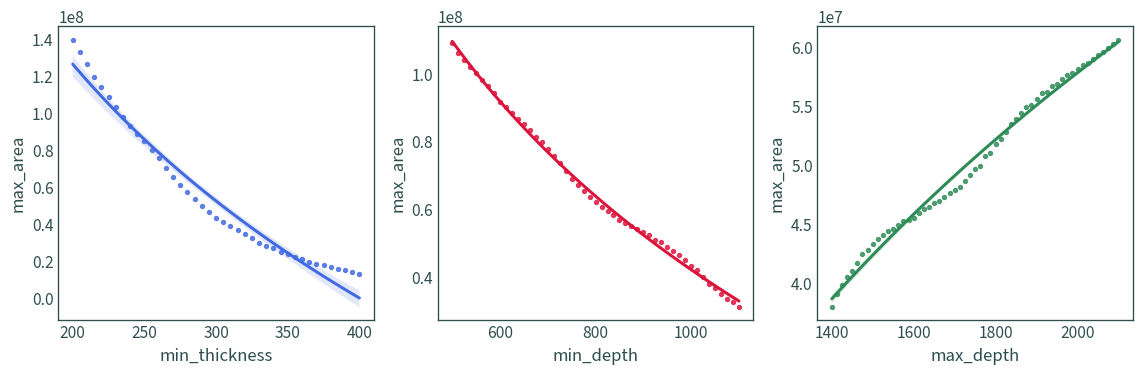

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for (n, key), c in zip(
    enumerate(sdf_max_depth.keys()), ["royalblue", "crimson", "seagreen"]
):
    sns.regplot(
        sdf_max_depth[key], x=key, y="max_area", logx=True, ax=axes[n],
        marker=".", color=c
    )
plt.tight_layout()
plt.show()

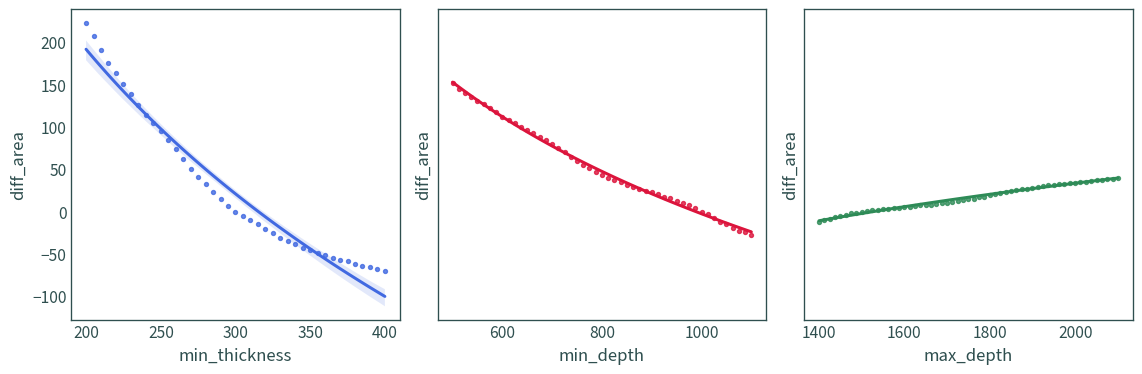

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for (n, key), c in zip(
    enumerate(sdf_max_depth.keys()), ["royalblue", "crimson", "seagreen"]
):
    sns.regplot(
        sdf_max_depth[key], x=key, y="diff_area", logx=True, ax=axes[n],
        marker=".", color=c
    )
plt.tight_layout()
plt.show()

### Without max depth

In [27]:
sdf_min_depth = sensitivity(zones_min_depth, include_max_depth=False)

In [28]:
for key in sdf_min_depth.keys():
    print(key)
    print(sdf_min_depth[key].describe())

min_thickness
           max_area  min_thickness   diff_area
count  4.100000e+01      41.000000   41.000000
mean   5.609073e+07     300.000000  -11.640309
std    3.806630e+07      59.895743   59.965813
min    1.312000e+07     200.000000  -79.332073
25%    2.364000e+07     250.000000  -62.759924
50%    4.328000e+07     300.000000  -31.821046
75%    8.456000e+07     350.000000   33.207309
max    1.395600e+08     400.000000  119.848771
min_depth
           max_area    min_depth  diff_area
count  4.900000e+01    49.000000  49.000000
mean   6.636082e+07   800.000000   4.538148
std    2.250140e+07   178.608627  35.446441
min    3.120000e+07   500.000000 -50.850662
25%    4.896000e+07   650.000000 -22.873346
50%    6.216000e+07   800.000000  -2.079395
75%    8.524000e+07   950.000000  34.278513
max    1.088800e+08  1100.000000  71.518589


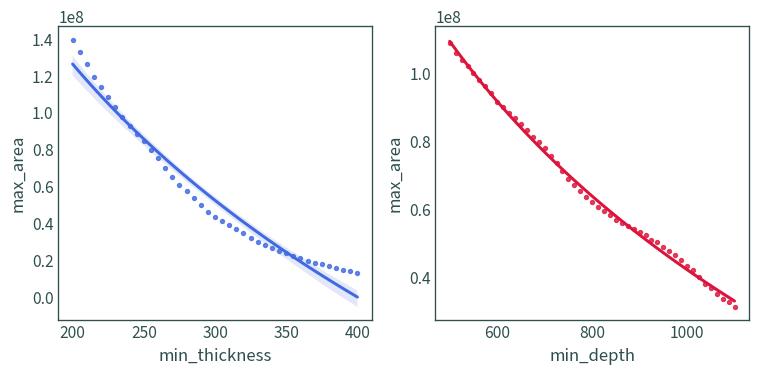

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for (n, key), c in zip(
    enumerate(sdf_min_depth.keys()), ["royalblue", "crimson", "seagreen"]
):
    sns.regplot(
        sdf_min_depth[key], x=key, y="max_area", logx=True, ax=axes[n],
        marker=".", color=c
    )
plt.tight_layout()
plt.show()

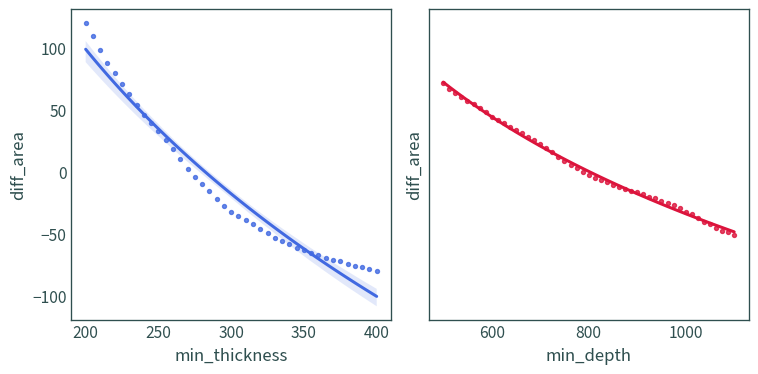

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
for (n, key), c in zip(
    enumerate(sdf_min_depth.keys()), ["royalblue", "crimson", "seagreen"]
):
    sns.regplot(
        sdf_min_depth[key], x=key, y="diff_area", logx=True, ax=axes[n],
        marker=".", color=c
    )
plt.tight_layout()
plt.show()